In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-02-02 14:53:50.813948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# import random

# random.seed(10)
# print(random.random())

In [4]:
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [5]:
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [6]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')

(array([1.7727e+04, 1.0511e+04, 6.4690e+03, 3.7450e+03, 2.2240e+03,
        1.3270e+03, 7.5900e+02, 4.6700e+02, 2.8700e+02, 1.5400e+02,
        7.2000e+01, 2.5000e+01, 7.0000e+00, 8.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([  0. ,  49.7,  99.4, 149.1, 198.8, 248.5, 298.2, 347.9, 397.6,
        447.3, 497. , 546.7, 596.4, 646.1, 695.8, 745.5, 795.2, 844.9,
        894.6, 944.3, 994. ]),
 <BarContainer object of 20 artists>)

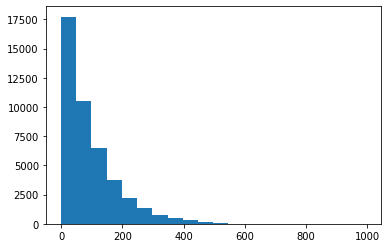

In [7]:
plt.hist(data['pollution'], bins=20)

In [8]:
np.percentile(data['pollution'], 95)

281.0

### Preprocess

In [9]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [10]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### PM threshold

In [12]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(30601,)
(6558,)
(6558,)


In [13]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.33400402414486924


### train_X_filter

In [14]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(848, 72, 11)
(848, 12)


In [15]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(29753, 72, 11)
(29753, 12)


### val_X_filter

In [16]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(752, 72, 11)
(752, 12)


In [17]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(5806, 72, 11)
(5806, 12)


### test_X_filter

In [19]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(581, 72, 11)
(581, 12)


In [20]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(5977, 72, 11)
(5977, 12)


### Model & training

In [21]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [23]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [24]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
#                                                           decay_steps=decay_steps,
#                                                           decay_rate=decay_rate)

# model.compile(optimizer=Adam(learning_rate=lr_schedule),
#               loss='mse',
#               metrics=['mae']
#              )

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models_mlp/pm_E.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X_extreme, train_y_extreme,
          validation_data=(val_X_extreme, val_y_extreme),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

2024-02-02 14:56:01.286872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-02 14:56:01.287656: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1700105000 Hz


Epoch 1/1000


2024-02-02 14:56:02.733237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2/2 - 3s - loss: 0.0328 - mae: 0.1261 - val_loss: 0.0643 - val_mae: 0.1678

Epoch 00001: val_mae improved from inf to 0.16779, saving model to ../../saved_models_mlp/pm_E.h5
Epoch 2/1000
2/2 - 0s - loss: 0.0288 - mae: 0.1117 - val_loss: 0.0544 - val_mae: 0.1471

Epoch 00002: val_mae improved from 0.16779 to 0.14706, saving model to ../../saved_models_mlp/pm_E.h5
Epoch 3/1000
2/2 - 0s - loss: 0.0221 - mae: 0.0952 - val_loss: 0.0395 - val_mae: 0.1347

Epoch 00003: val_mae improved from 0.14706 to 0.13466, saving model to ../../saved_models_mlp/pm_E.h5
Epoch 4/1000
2/2 - 0s - loss: 0.0187 - mae: 0.1066 - val_loss: 0.0354 - val_mae: 0.1410

Epoch 00004: val_mae did not improve from 0.13466
Epoch 5/1000
2/2 - 0s - loss: 0.0186 - mae: 0.1134 - val_loss: 0.0356 - val_mae: 0.1315

Epoch 00005: val_mae improved from 0.13466 to 0.13147, saving model to ../../saved_models_mlp/pm_E.h5
Epoch 6/1000
2/2 - 0s - loss: 0.0163 - mae: 0.0973 - val_loss: 0.0383 - val_mae: 0.1298

Epoch 00006: val_mae impr


Epoch 00047: val_mae did not improve from 0.08332
Epoch 48/1000
2/2 - 0s - loss: 0.0058 - mae: 0.0498 - val_loss: 0.0157 - val_mae: 0.0894

Epoch 00048: val_mae did not improve from 0.08332
Epoch 49/1000
2/2 - 0s - loss: 0.0057 - mae: 0.0491 - val_loss: 0.0141 - val_mae: 0.0841

Epoch 00049: val_mae did not improve from 0.08332
Epoch 50/1000
2/2 - 0s - loss: 0.0056 - mae: 0.0492 - val_loss: 0.0170 - val_mae: 0.0933

Epoch 00050: val_mae did not improve from 0.08332
Epoch 51/1000
2/2 - 0s - loss: 0.0057 - mae: 0.0496 - val_loss: 0.0142 - val_mae: 0.0842

Epoch 00051: val_mae did not improve from 0.08332
Epoch 52/1000
2/2 - 0s - loss: 0.0056 - mae: 0.0490 - val_loss: 0.0160 - val_mae: 0.0907

Epoch 00052: val_mae did not improve from 0.08332
Epoch 53/1000
2/2 - 0s - loss: 0.0055 - mae: 0.0483 - val_loss: 0.0144 - val_mae: 0.0854

Epoch 00053: val_mae did not improve from 0.08332
Epoch 54/1000
2/2 - 0s - loss: 0.0055 - mae: 0.0490 - val_loss: 0.0153 - val_mae: 0.0884

Epoch 00054: val_ma


Epoch 00104: val_mae did not improve from 0.08185
Epoch 105/1000
2/2 - 0s - loss: 0.0032 - mae: 0.0373 - val_loss: 0.0146 - val_mae: 0.0868

Epoch 00105: val_mae did not improve from 0.08185
Epoch 106/1000
2/2 - 0s - loss: 0.0032 - mae: 0.0373 - val_loss: 0.0130 - val_mae: 0.0806

Epoch 00106: val_mae improved from 0.08185 to 0.08058, saving model to ../../saved_models_mlp/pm_E.h5
Epoch 107/1000
2/2 - 0s - loss: 0.0034 - mae: 0.0395 - val_loss: 0.0159 - val_mae: 0.0914

Epoch 00107: val_mae did not improve from 0.08058
Epoch 108/1000
2/2 - 0s - loss: 0.0033 - mae: 0.0386 - val_loss: 0.0138 - val_mae: 0.0838

Epoch 00108: val_mae did not improve from 0.08058
Epoch 109/1000
2/2 - 0s - loss: 0.0031 - mae: 0.0372 - val_loss: 0.0148 - val_mae: 0.0872

Epoch 00109: val_mae did not improve from 0.08058
Epoch 110/1000
2/2 - 0s - loss: 0.0031 - mae: 0.0375 - val_loss: 0.0141 - val_mae: 0.0850

Epoch 00110: val_mae did not improve from 0.08058
Epoch 111/1000
2/2 - 0s - loss: 0.0030 - mae: 0.036


Epoch 00162: val_mae did not improve from 0.08058
Epoch 163/1000
2/2 - 0s - loss: 0.0019 - mae: 0.0306 - val_loss: 0.0142 - val_mae: 0.0865

Epoch 00163: val_mae did not improve from 0.08058
Epoch 164/1000
2/2 - 0s - loss: 0.0020 - mae: 0.0311 - val_loss: 0.0139 - val_mae: 0.0853

Epoch 00164: val_mae did not improve from 0.08058
Epoch 165/1000
2/2 - 0s - loss: 0.0020 - mae: 0.0315 - val_loss: 0.0149 - val_mae: 0.0890

Epoch 00165: val_mae did not improve from 0.08058
Epoch 166/1000
2/2 - 0s - loss: 0.0019 - mae: 0.0306 - val_loss: 0.0151 - val_mae: 0.0900

Epoch 00166: val_mae did not improve from 0.08058
Epoch 167/1000
2/2 - 0s - loss: 0.0019 - mae: 0.0307 - val_loss: 0.0145 - val_mae: 0.0876

Epoch 00167: val_mae did not improve from 0.08058
Epoch 168/1000
2/2 - 0s - loss: 0.0019 - mae: 0.0304 - val_loss: 0.0145 - val_mae: 0.0874

Epoch 00168: val_mae did not improve from 0.08058
Epoch 169/1000
2/2 - 0s - loss: 0.0019 - mae: 0.0307 - val_loss: 0.0145 - val_mae: 0.0877

Epoch 00169: